# Features x & y : Yves

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [3]:
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [4]:
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


### The number of backtracks in each path

d:\applications\miniconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\applications\miniconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


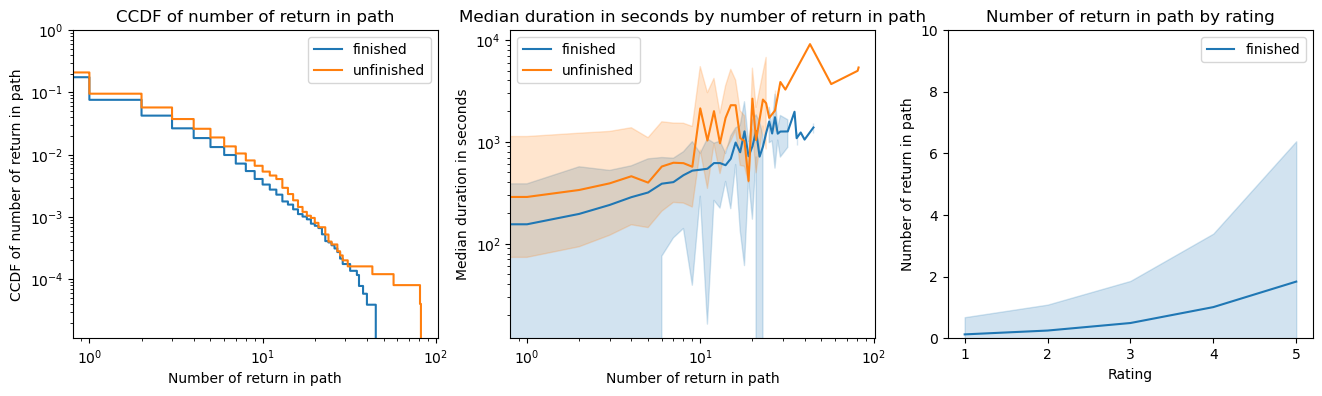

In [5]:
paths_finished["backtrack"]=paths_finished['path'].str.count('<')
paths_unfinished["backtrack"]=paths_unfinished["path"].str.count('<')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
sns.ecdfplot(paths_finished["backtrack"], label='finished', ax=axs[0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path', title='CCDF of number of return in path')
sns.ecdfplot(paths_unfinished["backtrack"], label='unfinished', ax=axs[0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path')
axs[0].legend()

sns.lineplot(paths_finished,x="backtrack",y="durationInSec", ax=axs[1],label="finished",errorbar="sd",estimator="median").set(xscale="log",yscale="log", ylabel='Median duration in seconds', xlabel='Number of return in path', title='Median duration in seconds by number of return in path')
sns.lineplot(paths_unfinished,x="backtrack",y="durationInSec", ax=axs[1],label="unfinished",errorbar="sd",estimator="median").set(xscale="log",yscale="log")
axs[1].legend()

sns.lineplot(paths_finished,x="rating",y="backtrack", ax=axs[2],label="finished",errorbar="sd").set(ylim=(0,10), ylabel='Number of return in path', xlabel='Rating', title='Number of return in path by rating')
axs[2].legend()

We can see that the number of return in a path seems to follow a power law distribution and that in unfinished paths you typically have more return. Moreover there is a positive trend between the median duration of the path and the number of return in the path, as expected. Similarly, the number of return has a tendancy to be higher for paths that were considered as more complex by the player.

### The number of paths previously attempted by the player for each path

There are 2 ip addresses with more than 400 paths played, they will be excluded from the following plots


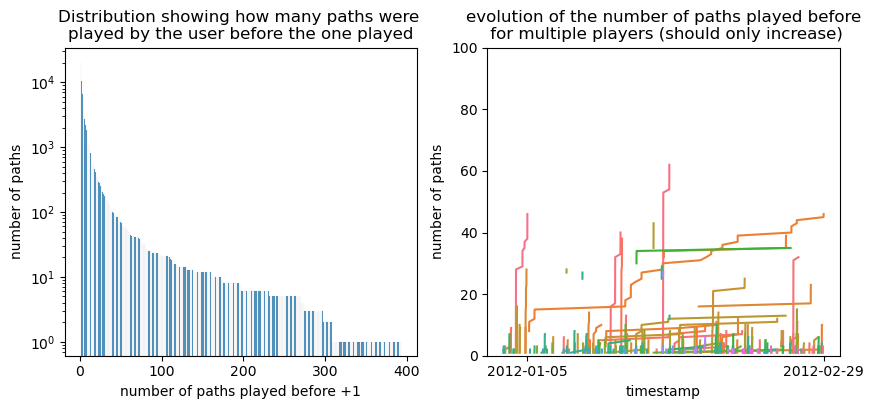

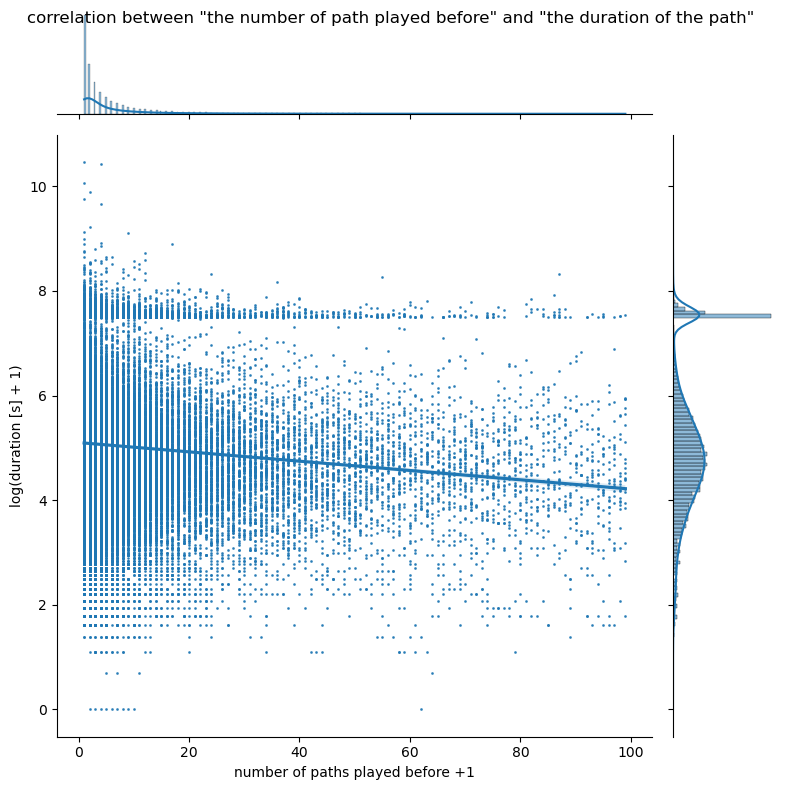

In [8]:
df_merged = pd.concat([paths_finished, paths_unfinished], ignore_index=True)
# for each row add a column with the number of path that the user has done before
#use cumcount on the groupby hashedIpAddress sorted by timestamp
df_merged['numberOfPath'] = df_merged.sort_values(by=['timestamp']).groupby('hashedIpAddress').cumcount() + 1
fig, axs = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

#how many users have more than 400 paths? (2)
print("There are", len(df_merged[df_merged['numberOfPath'] == 401]["hashedIpAddress"]),"ip addresses with more than 400 paths played, they will be excluded from the following plots")
#we will exclude them for the following plots
df_merged = df_merged[~df_merged["hashedIpAddress"].isin(df_merged[df_merged['numberOfPath'] == 401]["hashedIpAddress"])]

#plot the distribution of the number of path
sns.histplot(data=df_merged, x='numberOfPath', ax=axs[0]).set(yscale='log', title='Distribution showing how many paths were \nplayed by the user before the one played', xlabel='number of paths played before +1', ylabel='number of paths')
#check that the transformation is correct by looking if the number of path is increasing in function of the timestamp
#chose a sample of hashedIpAddress (we chosed randomly a 2 months window for better visualization)
sample = df_merged.loc[(df_merged["timestamp"] > '2012-01-01 00:00:00') & (df_merged["timestamp"] < '2012-03-01 00:00:00')]
sns.lineplot(data=sample, x='timestamp', y='numberOfPath', hue='hashedIpAddress', legend=False, ax=axs[1]).set(ylim=(0, 100), xticks=[sample['timestamp'].iloc[0], sample['timestamp'].iloc[-1]], xticklabels=[sample['timestamp'].iloc[0].strftime('%Y-%m-%d'), sample['timestamp'].iloc[-1].strftime('%Y-%m-%d')], title='evolution of the number of paths played before\n for multiple players (should only increase)', xlabel='timestamp', ylabel='number of paths')

#plot correlation between number of path and duration of the path
df_merged['durationInSecLog'] = np.log(df_merged['durationInSec']+1)
sns.jointplot(data=df_merged.loc[df_merged["numberOfPath"]<100], x='numberOfPath', y='durationInSecLog', kind='reg', height=8, scatter_kws={'s':1})
plt.suptitle('correlation between "the number of path played before" and "the duration of the path"')
plt.xlabel('number of paths played before +1')
plt.ylabel('log(duration [s] + 1)')
pass #avoid printing the object

We can see that the distribution of the number of paths previously attempted by the player for each path is decreasing (as expected), that only a few players made more than 100 paths (~300) and that usually the players play only one day or few days. Finally, we can see a negative correlation between the time spent in each path and the number of paths previously attempted by the player.